# Reassignment Tutorial for SM and ST Data

The purpose of this tutorial is to demonstrate the process of reassigning spatial transcriptomics (ST) and spatial metabolomics (SM) data to achieve accurate correspondence at each spatial spot. The differing resolutions of detection methods used in ST and SM hinder accurate correspondence, but this can be overcome using the reassignment function from the spatialMETA package.

Import necessary packages and libraries

In [1]:
cd ..

/home/rolan/Documents/spatialMETA


/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import spatialmeta as smt
import numpy as np
import pandas as pd
import scanpy as sc
from pyimzml.ImzMLParser import ImzMLParser

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Read and preprocess data

### Read SM data

In [5]:
adata_SM_aligned = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_SM_raw.aligned.h5ad")

In [6]:
adata_SM = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_SM_raw.h5ad")

In [7]:
adata_SM.obsm = adata_SM_aligned.obsm

In [8]:
adata_SM

AnnData object with n_obs × n_vars = 10649 × 1299
    obs: 'x_coord_original', 'y_coord_original', 'total_intensity_pos', 'mean_intensity_pos', 'total_intensity_neg', 'mean_intensity_neg', 'spot_index'
    var: 'name', 'type'
    obsm: 'spatial', 'spatial_normalized', 'spatial_transformed'

In [9]:
smt.pp.calculate_qc_metrics_sm(adata_SM)
adata_SM = smt.pp.filter_cells_sm(adata_SM,min_total_intensity=2e6)

Filtered 234 cells with total intensity less than 2000000.0


### Read ST data

In [10]:
adata_ST = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_ST_qc.h5ad")

In [11]:
adata_ST

AnnData object with n_obs × n_vars = 1914 × 36404
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

### Project H&E image into SM data

In [12]:
name = 'Y7_T'
adata_SM.obsm['spatial_transformed_scaled'] = adata_SM.obsm['spatial_transformed']/adata_ST.uns['spatial'][name]['scalefactors']['tissue_hires_scalef']
adata_SM.obsm['spatial'] = adata_SM.obsm['spatial_transformed_scaled']
adata_SM.uns['spatial'] = adata_ST.uns['spatial']

[<Axes: title={'center': 'total_intensity'}, xlabel='spatial1', ylabel='spatial2'>]

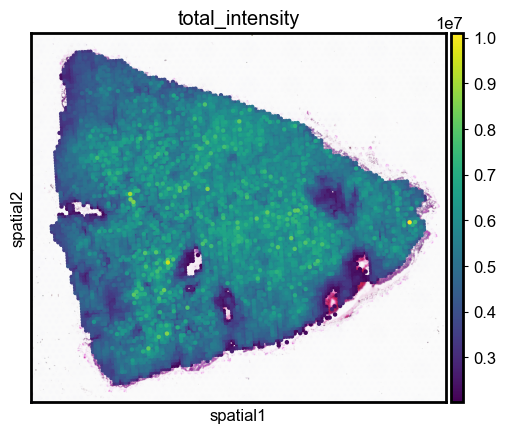

In [13]:
sc.pl.spatial(adata_SM, 
              img_key="hires", 
              color=["total_intensity"],
              show=False)

## Reassignment

### Resample in shared locations

In [17]:
smt.pp.calculate_min_diam(adata_ST)

366.0054644400818

In [18]:
smt.pp.calculate_min_diam(adata_SM)

147.9067840576172

In [14]:
new_dot_in_df = smt.pp.new_spot_sample(adata_SM,
                            adata_ST,
                            min_diam=300)

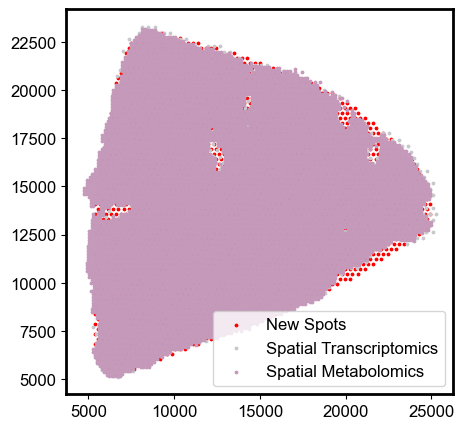

In [15]:
smt.pl.plot_newdot_sm_st(new_dot_in_df,
                         adata_SM,
                         adata_ST)

### New SM and ST data after reassignment

In [16]:
adata_SM_new, adata_ST_new = smt.pp.spot_align_byknn(new_dot_in_df,
                             adata_SM,
                             adata_ST,
                             min_diam=300,
                             min_dist_fold=1.5)

In [18]:
adata_ST_new.var["mt"] = adata_ST_new.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata_ST_new, qc_vars=["mt"], inplace=True)
smt.pp.calculate_qc_metrics_sm(adata_SM_new)

### visualization for new SM and ST data

[<Axes: title={'center': 'total_counts'}, xlabel='spatial1', ylabel='spatial2'>]

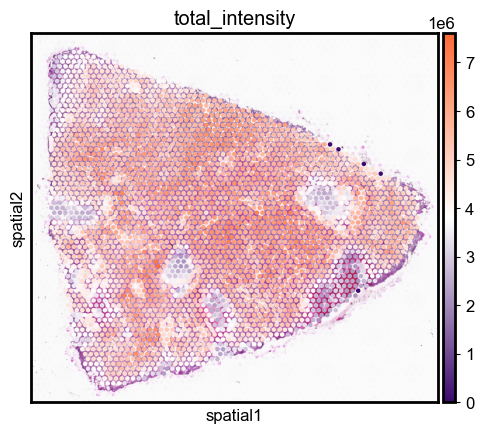

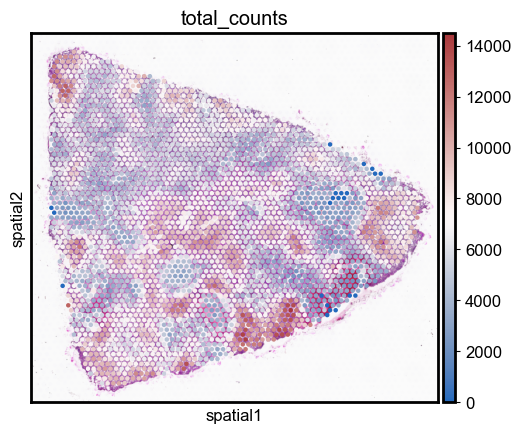

In [20]:
sc.pl.spatial(adata_SM_new, 
          img_key="hires", 
          color=["total_intensity"],
         #color_map = "vlag",
              cmap = smt.pl.make_colormap(['#3c096c','#FFFFFF','#ff6b35']),
          show=False)
sc.pl.spatial(adata_ST_new, 
          img_key="hires", 
          color=["total_counts"],
          color_map = "vlag",
          show=False)

## Joint ST and SM into one h5ad

### Quality control

<Axes: xlabel='mean_intensity', ylabel='Count'>

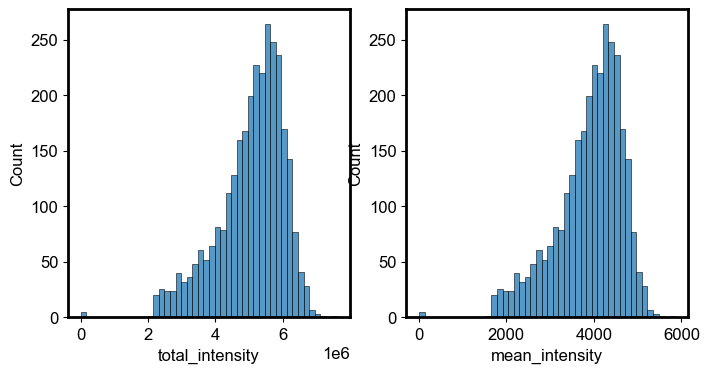

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(
    adata_SM_new.obs["total_intensity"], 
    kde=False, 
    ax=axs[0]
)
sns.histplot(
    adata_SM_new.obs["mean_intensity"],
    kde=False,
    ax=axs[1],
)

In [25]:
adata_SM_new = smt.pp.filter_cells_sm(adata_SM_new,min_total_intensity=2e6)

Filtered 5 cells with total intensity less than 2000000.0


<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

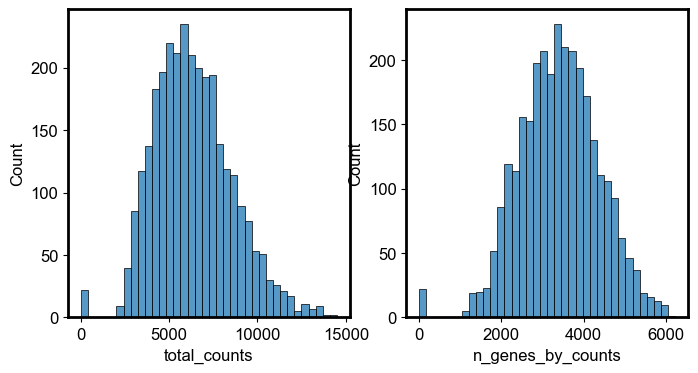

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(
    adata_ST_new.obs["total_counts"], 
    kde=False, 
    ax=axs[0]
)
sns.histplot(
    adata_ST_new.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)

In [26]:
sc.pp.filter_cells(adata_ST_new,min_counts=3000)
sc.pp.filter_cells(adata_ST_new,min_genes=1000)

In [27]:
adata_SM_new.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_SM_raw.new.h5ad")
adata_ST_new.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_ST_raw.new.h5ad")

### Joint ST and SM data

In [28]:
joint_adata = smt.pp.joint_adata_sm_st(
    adata_SM_new = adata_SM_new,
    adata_ST_new = adata_ST_new
)

In [29]:
joint_adata

Joint Spatial Transcriptomics and Metabolomics
AnnData object with n_obs × n_vars = {n_obs} × {n_vars}{backed_at}
    obs: 'x_coord', 'y_coord', 'spot_name', 'total_intensity', 'mean_intensity', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'name', 'type'
    uns: 'spatial'
    obsm: 'spatial'

[<Axes: title={'center': 'total_counts'}, xlabel='spatial1', ylabel='spatial2'>]

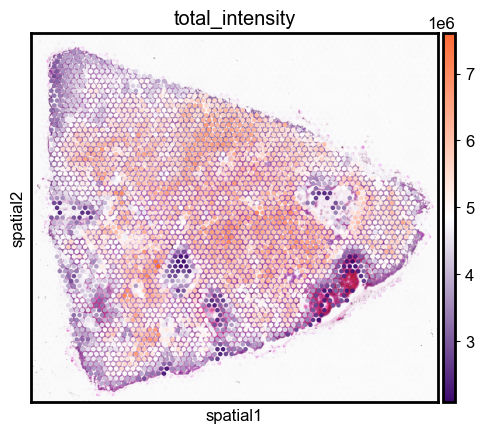

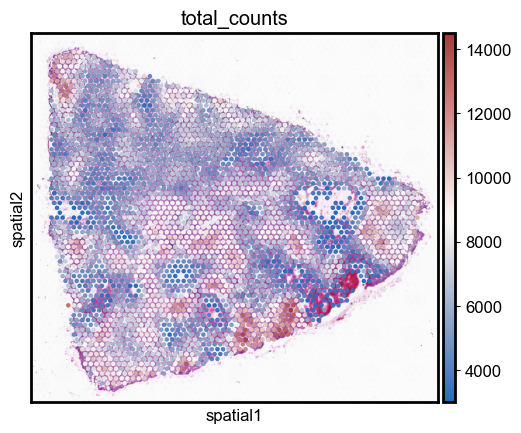

In [32]:
sc.pl.spatial(
    joint_adata, 
    img_key="hires", 
    color=["total_intensity"],
    cmap = smt.pl.make_colormap(['#3c096c','#FFFFFF','#ff6b35']),
    show=False
)
sc.pl.spatial(
    joint_adata, 
    img_key="hires", 
    color=["total_counts"],
    color_map = "vlag",
    show=False
)

Save the joint data as an h5ad file

In [33]:
joint_adata.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_raw.h5ad")